### Packages Required

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Input,Dense,Reshape,Flatten,Dropout,BatchNormalization,Activation,activation,ZeroPadding2D
from keras.layers.activation import LeakyReLU
from keras.layers.convolutional import UpSampling2D,conv2d,Conv2D
from keras.optimizers import Adam,SGD

### Datasets

In [6]:
(x,y),(_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 123s 1us/step


In [15]:
x = x[y.flatten()==8]

In [16]:
image_shape = (32,32,3)
latent_dim = 100

In [38]:
def build_generator():
    M0 = Sequential()
    M0.add(Dense(128*8*8,activation='relu',input_dim = latent_dim))
    M0.add(Reshape((8,8,128)))
    M0.add(UpSampling2D())
    
    M0.add(Conv2D(128,kernel_size =3,padding='same'))
    M0.add(BatchNormalization(momentum=0.78))
    M0.add(Activation('relu'))
    M0.add(UpSampling2D())
    
    M0.add(Conv2D(64,kernel_size =3,padding='same'))
    M0.add(BatchNormalization(momentum=0.78))
    M0.add(Activation('relu'))
    
    M0.add(Conv2D(3,kernel_size =3,padding='same'))
    M0.add(Activation('tanh'))
    
    noise = Input(shape=(latent_dim,))
    image = M0(noise)
    
    return Model(noise,image)

In [30]:
def build_discriminator():
    M1 = Sequential()
    M1.add(Conv2D(32,kernel_size = 3,strides=2,input_shape=image_shape,padding='same'))
    M1.add(LeakyReLU(alpha=0.2))
    M1.add(Dropout(0.25))
    
    M1.add(Conv2D(64,kernel_size = 3,strides=2,padding='same'))
    M1.add(ZeroPadding2D(padding=((0,1),(0,1))))
    M1.add(BatchNormalization(momentum=0.82))
    M1.add(LeakyReLU(alpha=0.25))
    M1.add(Dropout(0.25))
    
    M1.add(Conv2D(128,kernel_size = 3,strides=2,padding='same'))
    M1.add(BatchNormalization(momentum=0.82))
    M1.add(LeakyReLU(alpha=0.2))
    M1.add(Dropout(0.25))
    
    M1.add(Conv2D(256,kernel_size = 3,strides=2,padding='same'))
    M1.add(BatchNormalization(momentum=0.8))
    M1.add(LeakyReLU(alpha=0.25))
    M1.add(Dropout(0.25))
    
    M1.add(Flatten())
    M1.add(Dense(1,activation='sigmoid'))
    
    image = Input(shape=image_shape)
    validity = M1(image)
    
    return Model(image,validity)

In [47]:
def display_image():
    r,c = 4,4
    noise = np.random.normal(0,1,(r*c,latent_dim))
    generated_images = generator.predict(noise)
    
    generated_images = 0.5*generated_images + 0.5
    
    fig,axs = plt.subplots(r,c)
    count = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(generated_images[count, :,:,])
            axs[i,j].axis('off')
            count += 1
        plt.show()
        plt.close()

In [33]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5),metrics=['accuracy'])
discriminator.trainable = False

In [42]:
generator = build_generator()
z = Input(shape=(latent_dim,))
image = generator(z)

valid = discriminator(image)

combined_network = Model(z,valid)
combined_network.compile(loss='binary_crossentropy',optimizer=Adam(0.002,0.5))

In [44]:
image

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'model_4')>

1/1 [==============================] - 0s 63ms/step


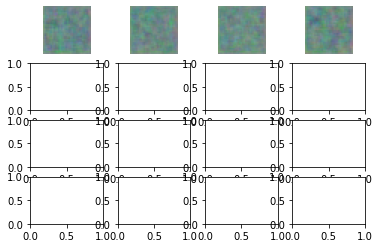

1/1 [==============================] - 0s 79ms/step


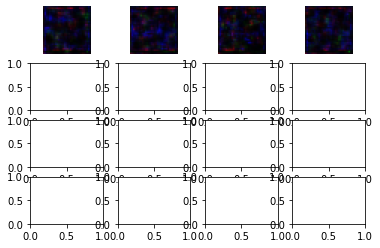

1/1 [==============================] - 0s 83ms/step


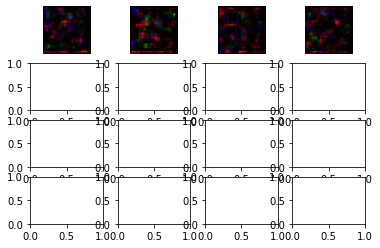

1/1 [==============================] - 0s 70ms/step


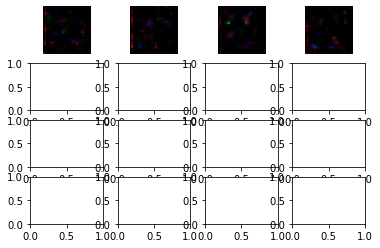

1/1 [==============================] - 0s 96ms/step


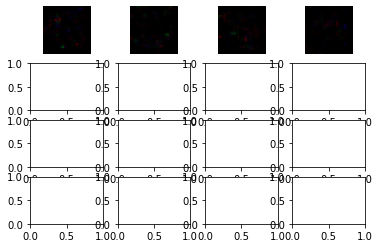

1/1 [==============================] - 0s 72ms/step


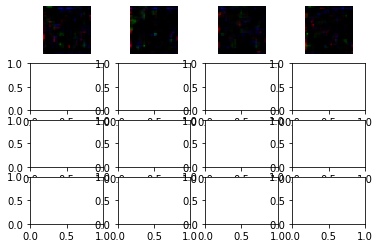

1/1 [==============================] - 0s 65ms/step


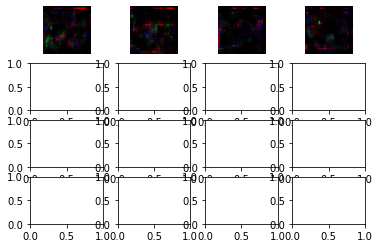

1/1 [==============================] - 0s 65ms/step


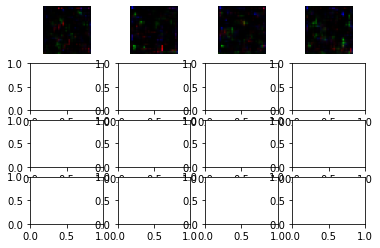

1/1 [==============================] - 0s 63ms/step


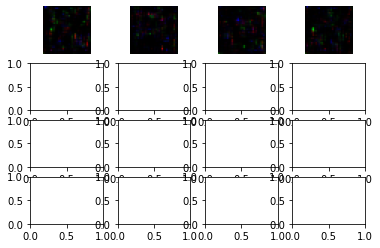

1/1 [==============================] - 0s 72ms/step


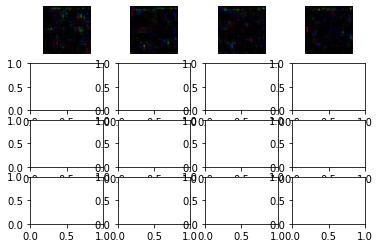

1/1 [==============================] - 0s 100ms/step


In [48]:
num_epochs = 100
batch_size = 32
display_interval = 10
losses = []

x = (x/127.5) -1

valid = np.ones((batch_size,1))

valid += 0.05* np.random.random(valid.shape)
fake = np.zeros((batch_size,1))
fake += 0.05*np.random.random(fake.shape)

for epoch in range(num_epochs):
    index = np.random.randint(0,x.shape[0],batch_size)
    images = x[index]
    
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    generated_images = generator.predict(noise)
    
    discm_loss_real = discriminator.train_on_batch(images,valid)
    discm_loss_fake = discriminator.train_on_batch(generated_images,fake)
    discm_loss = 0.5*np.add(discm_loss_real,discm_loss_fake)
    
    genr_loss = combined_network.train_on_batch(noise,valid)
    
    if epoch % display_interval == 0:
        display_image()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

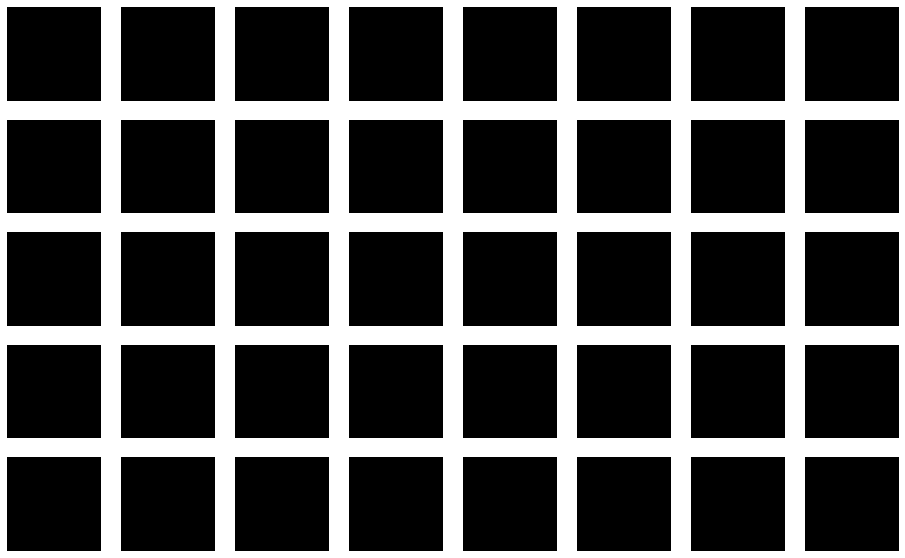

In [50]:
s = x[:40]
s = 0.5*s + 0.5
f,ax = plt.subplots(5,8,figsize=(16,10))
for i,image in enumerate(s):
    ax[i//8,i%8].imshow(image)
    ax[i//8,i%8].axis('off')
    
plt.show()

2/2 [==============================] - 0s 16ms/step


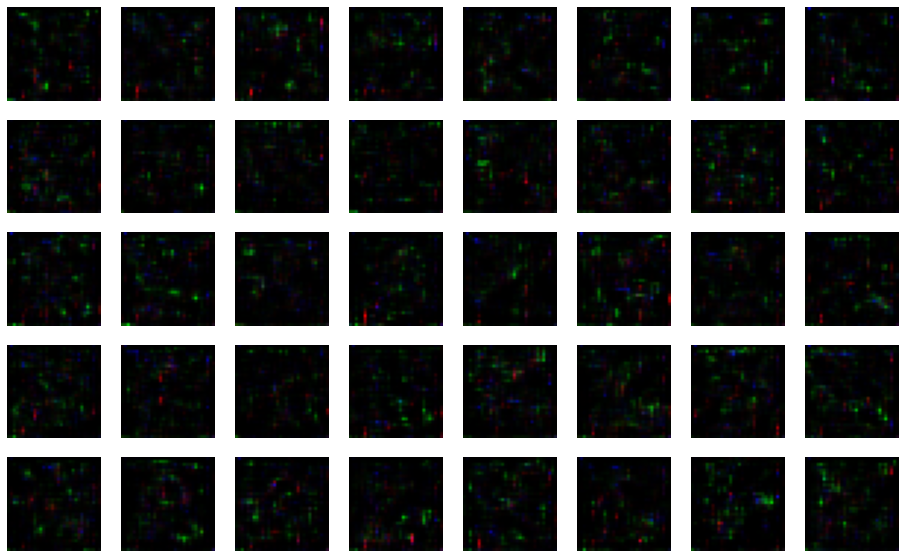

In [51]:
noise = np.random.normal(size=(40,latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5* generated_images + 0.5
f,ax = plt.subplots(5,8,figsize=(16,10))
for i,image in enumerate(generated_images):
    ax[i//8,i%8].imshow(image)
    ax[i//8,i%8].axis('off')
    
plt.show()